# Similarity Queries using Annoy Tutorial

This tutorial is about using the [Annoy(Approximate Nearest Neighbors Oh Yeah)]((https://github.com/spotify/annoy "Link to annoy repo") library for similarity queries in gensim

## Why use Annoy?
The current implementation for finding k nearest neighbors in a vector space in gensim has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors. The retrieved results are exact, which is an overkill in many applications: approximate results retrieved in sub-linear time may be enough. Annoy can find approximate nearest neighbors much faster.

For the following examples, we'll use the Lee Corpus (which you already have if you've installed gensim)

See the [Word2Vec tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb) for how to initialize and save this model.

In [1]:
# Load the model
import gensim, os
from gensim.models.word2vec import Word2Vec

# Set file names for train and test data
test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data']) + os.sep
lee_train_file = test_data_dir + 'lee_background.cor'

class MyText(object):
    def __iter__(self):
        for line in open(lee_train_file):
            # assume there's one document per line, tokens separated by whitespace
            yield gensim.utils.simple_preprocess(line)

sentences = MyText()
model = Word2Vec(sentences, min_count=1)
print(model)

Word2Vec(vocab=6981, size=100, alpha=0.025)



#### Comparing the traditional implementation and the Annoy  


These benchmarks are run on a 2.4GHz 4 core i7 processor  

In [2]:
#Set up the model and vector that we are using in the comparison
try:
    from gensim.similarities.index import AnnoyIndexer
except ImportError:
    raise ValueError("SKIP: Please install the annoy indexer")

model.init_sims()
annoy_index = AnnoyIndexer(model, 300)

In [3]:
# Dry run to make sure both indices are fully in RAM
vector = model.wv.syn0norm[0]
model.most_similar([vector], topn=5, indexer=annoy_index)
model.most_similar([vector], topn=5)

[(u'the', 1.0),
 (u'on', 0.999976396560669),
 (u'in', 0.9999759197235107),
 (u'two', 0.9999756217002869),
 (u'after', 0.9999749660491943)]

In [4]:
import time, numpy

def avg_query_time(annoy_index=None):
    """
    Average query time of a most_similar method over 1000 random queries,
    uses annoy if given an indexer
    """
    total_time = 0
    for _ in range(1000):
        rand_vec = model.wv.syn0norm[numpy.random.randint(0, len(model.vocab))]
        start_time = time.clock()
        model.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.clock() - start_time
    return total_time / 1000

gensim_time = avg_query_time()
annoy_time = avg_query_time(annoy_index)
print "Gensim: {}".format(gensim_time) 
print "Annoy: {}".format(annoy_time)
print "\nAnnoy is {} times faster on average over 1000 random queries on \
this particular run".format(numpy.round(gensim_time / annoy_time, 2))

Gensim: 0.002638526
Annoy: 0.001149898

Annoy is 2.29 times faster on average over 1000 random queries on this particular run



**This speedup factor is by no means constant** and will vary greatly from run to run and is particular to this data set, BLAS setup, Annoy parameters(as tree size increases speedup factor decreases), machine specifications, among other factors.

>**Note**: Initialization time for the annoy indexer was not included in the times. The optimal knn algorithm for you to use will depend on how many queries you need to make and the size of the corpus. If you are making very few similarity queries, the time taken to initialize the annoy indexer will be longer than the time it would take the brute force method to retrieve results. If you are making many queries however, the time it takes to initialize the annoy indexer will be made up for by the incredibly fast retrieval times for queries once the indexer has been initialized

>**Note** : Gensim's 'most_similar' method is using numpy operations in the form of dot product whereas Annoy's method isnt. If 'numpy' on your machine is using one of the BLAS libraries like ATLAS or LAPACK, it'll run on multiple cores(only if your machine has multicore support ). Check [SciPy Cookbook](http://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html) for more details.

## What is Annoy?

Annoy is an open source library to search for points in space that are close to a given query point. It also creates large read-only file-based data structures that are mmapped into memory so that many processes may share the same data. For our purpose, it is used to find similarity between words or documents in a vector space. [See the tutorial on similarity queries for more information on them](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Similarity_Queries.ipynb).

## Getting Started

First thing to do is to install annoy, by running the following in the command line:

`sudo pip install annoy`

And then set up the logger: 

In [5]:
# import modules & set up logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Making a Similarity Query

### Creating an indexer
An instance of `AnnoyIndexer` needs to be created in order to use Annoy in gensim. The `AnnoyIndexer` class is located in `gensim.similarities.index`

`AnnoyIndexer()` takes two parameters:

**`model`**: A `Word2Vec` or `Doc2Vec` model

**`num_trees`**: A positive integer. `num_trees` effects the build time and the index size. **A larger value will give more accurate results, but larger indexes**. More information on what trees in Annoy do can be found [here](https://github.com/spotify/annoy#how-does-it-work). The relationship between `num_trees`, build time, and accuracy will be investigated later in the tutorial. 


In [6]:
from gensim.similarities.index import AnnoyIndexer
# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model, 100)

Now that we are ready to make a query, lets find the top 5 most similar words to "army" in the lee corpus. To make a similarity query we call `Word2Vec.most_similar` like we would traditionally, but with an added parameter, `indexer`. The only supported indexer in gensim as of now is Annoy. 

In [7]:
# Derive the vector for the word "science" in our model
vector = model["science"]
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.most_similar([vector], topn=5, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print(neighbor)

(u'science', 0.9998273665260058)
(u'rates', 0.9086664393544197)
(u'insurance', 0.9080813005566597)
(u'north', 0.9077721834182739)
(u'there', 0.9076579436659813)


### Analyzing the results

The closer the cosine similarity of a vector is to 1, the more similar that word is to our query, which was the vector for "science".

## Persisting Indexes
You can save and load your indexes from/to disk to prevent having to construct them each time. This will create two files on disk, _fname_ and _fname.d_. Both files are needed to correctly restore all attributes. Before loading an index, you will have to create an empty AnnoyIndexer object.

In [8]:
fname = 'index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

In [9]:
# Results should be identical to above
vector = model["science"]
approximate_neighbors = model.most_similar([vector], topn=5, indexer=annoy_index2)
for neighbor in approximate_neighbors:
    print neighbor

(u'science', 0.9998273665260058)
(u'rates', 0.9086666032671928)
(u'insurance', 0.9080811440944672)
(u'north', 0.9077721834182739)
(u'there', 0.9076577797532082)


Be sure to use the same model at load that was used originally, otherwise you will get unexpected behaviors.

## Save memory by memory-mapping indices saved to disk

Annoy library has a useful feature that indices can be memory-mapped from disk. It saves memory when the same index is used by several processes.

Below are two snippets of code. First one has a separate index for each process. The second snipped shares the index between two processes via memory-mapping. The second example uses less total RAM as it is shared.

In [10]:
%%time

# Bad example. Two processes load the Word2vec model from disk and create there own Annoy indices from that model. 

from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os
import psutil

model.save('/tmp/mymodel')

def f(process_id):
    print 'Process Id: ', os.getpid()
    process = psutil.Process(os.getpid())
    new_model = models.Word2Vec.load('/tmp/mymodel')
    vector = new_model["science"]
    annoy_index = AnnoyIndexer(new_model,100)
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=annoy_index)
    for neighbor in approximate_neighbors:
        print neighbor
    print 'Memory used by process '+str(os.getpid())+'=', process.memory_info()

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id:  6216
(u'klusener', 0.9090957194566727)
(u'started', 0.908975400030613)
(u'gutnick', 0.908865213394165)
(u'ground', 0.9084076434373856)
(u'interest', 0.9074432477355003)
Memory used by process 6216= pmem(rss=126914560, vms=1385103360, shared=9273344, text=3051520, lib=0, data=1073524736, dirty=0)
Process Id:  6231
(u'klusener', 0.9090957194566727)
(u'started', 0.908975400030613)
(u'gutnick', 0.908865213394165)
(u'ground', 0.9084076434373856)
(u'interest', 0.9074432477355003)
Memory used by process 6231= pmem(rss=126496768, vms=1385103360, shared=8835072, text=3051520, lib=0, data=1073524736, dirty=0)
CPU times: user 64 ms, sys: 12 ms, total: 76 ms
Wall time: 2.86 s


In [11]:
%%time

# Good example. Two processes load both the Word2vec model and index from disk and memory-map the index

from gensim import models
from gensim.similarities.index import AnnoyIndexer
from multiprocessing import Process
import os
import psutil

model.save('/tmp/mymodel')

def f(process_id):
    print 'Process Id: ', os.getpid()
    process = psutil.Process(os.getpid())
    new_model = models.Word2Vec.load('/tmp/mymodel')
    vector = new_model["science"]
    annoy_index = AnnoyIndexer()
    annoy_index.load('index')
    annoy_index.model = new_model
    approximate_neighbors = new_model.most_similar([vector], topn=5, indexer=annoy_index)
    for neighbor in approximate_neighbors:
        print neighbor
    print 'Memory used by process '+str(os.getpid()), process.memory_info()

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',))
p1.start()
p1.join()
p2 = Process(target=f, args=('2',))
p2.start()
p2.join()

Process Id:  6246
(u'science', 0.9998273665260058)
(u'rates', 0.9086664393544197)
(u'insurance', 0.9080813005566597)
(u'north', 0.9077721834182739)
(u'there', 0.9076579436659813)
Memory used by process 6246 pmem(rss=125091840, vms=1382862848, shared=22179840, text=3051520, lib=0, data=1058062336, dirty=0)
Process Id:  6261
(u'science', 0.9998273665260058)
(u'rates', 0.9086664393544197)
(u'insurance', 0.9080813005566597)
(u'north', 0.9077721834182739)
(u'there', 0.9076579436659813)
Memory used by process 6261 pmem(rss=125034496, vms=1382862848, shared=22122496, text=3051520, lib=0, data=1058062336, dirty=0)
CPU times: user 44 ms, sys: 16 ms, total: 60 ms
Wall time: 202 ms


# Relationship between num_trees and initialization time

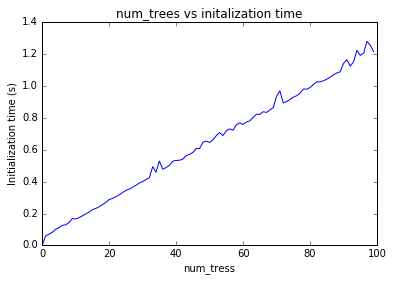

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt, time
x_cor = []
y_cor = []
for x in range(100):
    start_time = time.time()
    AnnoyIndexer(model, x)
    y_cor.append(time.time()-start_time)
    x_cor.append(x)

plt.plot(x_cor, y_cor)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_tress")
plt.show()

Initialization time of the annoy indexer increases in a linear fashion with num_trees. Initialization time will vary from corpus to corpus, in the graph above the lee corpus was used

# Relationship between num_trees and accuracy

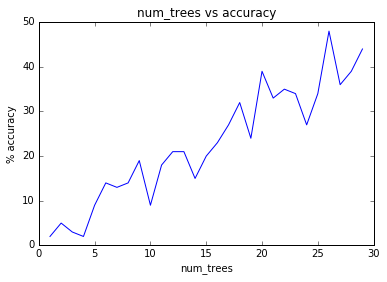

In [13]:
exact_results = [element[0] for element in model.most_similar([model.wv.syn0norm[0]], topn=100)]
x_axis = []
y_axis = []
for x in range(1,30):
    annoy_index = AnnoyIndexer(model, x)
    approximate_results = model.most_similar([model.wv.syn0norm[0]],topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    x_axis.append(x)
    y_axis.append(len(set(top_words).intersection(exact_results)))
    
plt.plot(x_axis, y_axis)
plt.title("num_trees vs accuracy")
plt.ylabel("% accuracy")
plt.xlabel("num_trees")
plt.show()

This was again done with the lee corpus, a relatively small corpus. Results will vary from corpus to corpus